# Project Report Notebook - Football Transfer Analytics

[Executive_Summary](#Executive_Summary)
<br>[Table of Contents Introduction](#Table_of_Contents_Introduction)
<br>[Analysis](#analysis)
<br>[Conclusion](#conclusion)
<br>[Appendix: Project Structure](#Project_Structure)

---
## Executive Summary <a id='Executive_Summary'></a>

The question: What recipy a football player should follow in order to increase his market value the most?


Purpose: We want to analyze what are the most important factors that might increase the value of a player when he transfers from one club to another. Hence, we built a network by taking 10 years of historical data and computed different centrality measurements in order to find out valuable information using machine learning algorithms.

Network: Transfers of professional and semi-professional football players.
Type: Directed and weighted network
Source: TransferMarket.
Modification: We have scrapped the clubs that have a total market value above 200 million euros. From these clubs, we downloaded the html files of their football players. This include the nationality, birthdate, transfer history, transfer fee etc.

In [14]:
from urllib.request import *
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as pl
import requests
from geopy.geocoders import Nominatim
import json
import folium
import os
import time
from tempfile import TemporaryFile
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
import networkx as nx
from pylab import rcParams
%matplotlib inline

# ML related libraries
from sklearn.linear_model import Lasso
import copy
from sklearn.externals import joblib
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import sklearn.svm as svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

from models import *
from helpers import *

## Loading clubs data

In [ ]:
with open("../scraper/data/clubs.json", "r") as in_file:
    clubs = json.load(in_file)
print("There are " + str(len(clubs)) + " clubs")
clubs[0]

# Dictionary of club id to name
club_name_id = dict()
for club in clubs:
    club_name_id[club['href'].split("/")[4]] = club['name']

## Loading players

In [3]:
with open("../scraper/data/players_ref.json", "r") as in_file:
    players_ref_list = json.load(in_file)

club_ids = []
for club in clubs:
    club_ids.append(int(club['href'].split("/")[-3]))
    
print ("We have {} players".format(len(players_ref_list)))

We have 12075 players


In [4]:
# This function will transform the fees of a player from a string to a number so that it can be used as a weight for the edges
def fix_fee(player_fee):
    try:
        player_fee = player_fee.replace(":",": ").replace(",",".")
    except:
        pass
    if re.search(r'\d+.\d+', player_fee) is not None:
        fee = float(re.search(r'\d+.\d+', player_fee).group())
    else:
        fee = 0
    
    if fee > 0:
        if "Mill." in player_fee:
            processed_fee = int(fee*1000000)
        elif "Th." in player_fee:
            processed_fee = int(fee*1000)
        else:
            processed_fee = int(fee)
    else:
        processed_fee = 0
    
    return processed_fee

# Returns the year of the transfer
def get_year(date):
    return date[-4:]

# Define method to parse player given player url
def parsePlayer(player_ref):    
    playerID = player_ref.split("/")[-1]
    
    with open("../scraper/data/players/" + playerID + "/page.html") as in_file:
        player_page = json.load(in_file)
    
    response = BeautifulSoup(player_page, 'html.parser')
    
    playerInfos = str(response.find("table", {"class":"auflistung"}))
    player = {}
    player["href"] = player_ref
    try:
        player["number"] = response.find("span", {"class":"dataRN"}).text
    except:
        player["number"] = None
    player["name"] = response.find("h1", {"itemprop":"name"}).text
    player["player_id"] = player_ref.split("/")[-1]
    position = BeautifulSoup(playerInfos.split("Position")[1], 'html.parser').find("td").text
    reg = re.compile( "[a-zA-Z -]")
    player["position"] = "".join(reg.findall(position))
    try:
        player["birthdate"] = BeautifulSoup(playerInfos.split("Date of birth")[1], 'html.parser').find("td").text
    except:
        player["birthdate"] = None
    player["nationality"] = BeautifulSoup(playerInfos.split("Nationality")[1], 'html.parser').find("td").find("img")["title"]
    player["current_club"] = BeautifulSoup(playerInfos.split("Current club")[1], 'html.parser').find("td").find_all("a")[-1].text

    try:
        transfers = []
        trans = response.find("div",{"class" : "box transferhistorie"}).find("table").find("tbody").find_all("tr", {"class":"zeile-transfer"})

        for t in trans:
            transfer = {}
            transfer["player"] = player_ref.split("/")[-1]
            transfer["date"] = t.find_all("td", {"class":"zentriert hide-for-small"})[1].text
            transfer["from"] = t.find_all("td", {"class":"no-border-rechts vereinswappen"})[0].find("a")["id"]
            transfer["to"] = t.find_all("td", {"class":"no-border-rechts vereinswappen"})[1].find("a")["id"]
            if (t.find("td", {"class":"zelle-abloese"}).text) == "End of loan" or t.find("td", {"class":"zelle-abloese"}).text =="Loan":
                transfer["fee"] = t.find("td", {"class":"zelle-mw"}).text
            else:
                transfer["fee"] = t.find("td",{"class":"zelle-abloese"}).text
            transfer["fee"] = fix_fee(transfer["fee"])
            transfers.append(transfer)
    except:
        transfers = None
        
    return player, transfers


def get_club_value(club_id):
    for club in clubs:
        if (int(club['href'].split("/")[-3]) == club_id):
            return fix_fee(club['market_value'])
    

In [5]:
# Example test of what the function would return
player_test = parsePlayer(players_ref_list[0])
player_test

({'birthdate': 'May 11, 1992 ',
  'current_club': 'Chelsea FC',
  'href': '/thibaut-courtois/profil/spieler/108390',
  'name': 'Thibaut Courtois',
  'nationality': 'Belgium',
  'number': '#13',
  'player_id': '108390',
  'position': 'Goalkeeper'},
 [{'date': 'Jun 30, 2014',
   'fee': 25000000,
   'from': '13',
   'player': '108390',
   'to': '631'},
  {'date': 'Jul 27, 2011',
   'fee': 1200000,
   'from': '631',
   'player': '108390',
   'to': '13'},
  {'date': 'Jul 26, 2011',
   'fee': 8950000,
   'from': '1184',
   'player': '108390',
   'to': '631'},
  {'date': 'Jul 1, 2009',
   'fee': 0,
   'from': '3494',
   'player': '108390',
   'to': '1184'},
  {'date': 'Jul 1, 2008',
   'fee': 0,
   'from': '49393',
   'player': '108390',
   'to': '3494'},
  {'date': 'Jul 1, 2007',
   'fee': 0,
   'from': '34282',
   'player': '108390',
   'to': '49393'}])

## Build graph and dataframe of transfers

In [6]:
# Do not run this cell as it will take a lot of time
transfer = {'from_club_id': [],
            'to_club_id': [],
            'player_nationality': [],
            'value_increase': [],
            'player_stay_in_years': [],
            'club_market_value_from': [],
            'club_market_value_to': [],
            'transfer_year': [],
            'position': [],
            'birth_date_year': []
            }

G = nx.DiGraph()
# Go through all the players
for player_ref in players_ref_list:
    player = parsePlayer(player_ref)
    # Check that player has more than 1 transfer recorded
    if player[1] is not None and len(player[1])>1:
        # Get initial recorded transfer
        year_start = int(get_year(player[1][-1]["date"].strip()))
        # Loop over player transfers from oldest to most recent
        for index in range(2,len(player[1])+1):
            # Compute the number of years a player stayed in the club before he transfered
            player_stay = int(get_year(player[1][-index]["date"].strip())) - year_start
            # Update year_start
            year_start = int(get_year(player[1][-index]["date"].strip()))
            # Only consider the switch when a player stayed less than 5 years in a club
            if (player_stay <= 5):
                from_club = int(player[1][-index]["from"])
                to_club = int(player[1][-index]["to"])
                # Only considering transfers between clubs whose value is above 200 million euros
                if(from_club in club_ids and to_club in club_ids):
                    # Value increase/decrease in a player compared to previous transfer
                    value_increase = player[1][-index]["fee"] - player[1][-index+1]["fee"]
                    # Add entry to dataframe
                    transfer['from_club_id'].append(from_club)
                    transfer['to_club_id'].append(to_club)
                    transfer['player_nationality'].append(player[0]['nationality'])
                    transfer['value_increase'].append(value_increase)
                    transfer['player_stay_in_years'].append(player_stay)
                    transfer['club_market_value_from'].append(get_club_value(from_club))
                    transfer['club_market_value_to'].append(get_club_value(to_club))
                    transfer['transfer_year'].append(get_year(player[1][-index]['date'].strip()))
                    transfer['position'].append(player[0]['position'])
                    transfer['birth_date_year'].append(get_year(player[0]['birthdate'].strip()))
                    # Build graph from the transfer. Node is a club
                    # add two attributes: transfer fee between clubs and number of transfers
                    if G.has_edge(from_club, to_club):
                        G[from_club][to_club]["transfer_fee"] += player[1][-index]["fee"]
                        G[from_club][to_club]["num_transfers"] += 1
                    else:
                        G.add_edge(from_club, to_club, transfer_fee=player[1][-index]["fee"], num_transfers=1)

In [ ]:
df = pd.DataFrame(transfer, columns= ['from_club_id', 'to_club_id','player_nationality','value_increase','player_stay_in_years','club_market_value_from','club_market_value_to','transfer_year','position','birth_date_year'])

### Add graph measures to each row

In [8]:
# Unweighted Degree centrality
unweighted_in_degree_centrality_list = nx.in_degree_centrality(G)
unweighted_out_degree_centrality_list = nx.out_degree_centrality(G)

# Other measures
closeness_centrality_list = nx.closeness_centrality(G)
closeness_fee_centrality_list = nx.closeness_centrality(G,distance='transfer_fee')
unweighted_betweenness_centrality_list = nx.betweenness_centrality(G)
weighted_fee_betweenness_centrality_list = nx.betweenness_centrality(G, weight='transfer_fee')
weighted_transfers_betweenness_centrality_list = nx.betweenness_centrality(G, weight='num_transfers')
weighted_fee_pagerank_list = nx.pagerank(G, weight="transfer_fee")
weighted_transfers_pagerank_list = nx.pagerank(G, weight="num_transfers")
unweighted_eigenvector_list = nx.eigenvector_centrality(G)
weighted_fee_eigenvector_list = nx.eigenvector_centrality(G, weight="transfer_fee")
weighted_transfers_eigenvector_list = nx.eigenvector_centrality(G, weight="num_transfers")


In [14]:
# Add column measurements
# Replace in_degree
df['from_in_degree'] = df['from_club_id'].map(lambda x: unweighted_in_degree_centrality_list[x])
df['to_in_degree'] = df['to_club_id'].map(lambda x: unweighted_in_degree_centrality_list[x])

# Replace out_degree
df['from_out_degree'] = df['from_club_id'].map(lambda x: unweighted_out_degree_centrality_list[x])
df['to_out_degree'] = df['to_club_id'].map(lambda x: unweighted_out_degree_centrality_list[x])

# Replace closeness
df['from_closeness'] = df['from_club_id'].map(lambda x: closeness_centrality_list[x])
df['to_closeness'] = df['to_club_id'].map(lambda x: closeness_centrality_list[x])

# Replace fee closeness
df['from_fee_closeness'] = df['from_club_id'].map(lambda x: closeness_fee_centrality_list[x])
df['to_fee_closeness'] = df['to_club_id'].map(lambda x: closeness_fee_centrality_list[x])

# Unweighted betweenness
df['from_betweenness'] = df['from_club_id'].map(lambda x: unweighted_betweenness_centrality_list[x])
df['to_betweenness'] = df['to_club_id'].map(lambda x: unweighted_betweenness_centrality_list[x])

# Weighted fee betweenness
df['from_fee_betweenness'] = df['from_club_id'].map(lambda x: weighted_fee_betweenness_centrality_list[x])
df['to_fee_betweenness'] = df['to_club_id'].map(lambda x: weighted_fee_betweenness_centrality_list[x])

# Weighted transfers betweenness
df['from_transfers_betweenness'] = df['from_club_id'].map(lambda x: weighted_transfers_betweenness_centrality_list[x])
df['to_transfers_betweenness'] = df['to_club_id'].map(lambda x: weighted_transfers_betweenness_centrality_list[x])

# Weighted fee pagerank
df['from_fee_pagerank'] = df['from_club_id'].map(lambda x: weighted_fee_pagerank_list[x])
df['to_fee_pagerank'] = df['to_club_id'].map(lambda x: weighted_fee_pagerank_list[x])

# Weighted transfers pagerank
df['from_transfers_pagerank'] = df['from_club_id'].map(lambda x: weighted_transfers_pagerank_list[x])
df['to_transfers_pagerank'] = df['to_club_id'].map(lambda x: weighted_transfers_pagerank_list[x])

# Unweighted eigenvector
df['from_eigenvector'] = df['from_club_id'].map(lambda x: unweighted_eigenvector_list[x])
df['to_eigenvector'] = df['to_club_id'].map(lambda x: unweighted_eigenvector_list[x])

# Weighted fee eigenvector
df['from_fee_eigenvector'] = df['from_club_id'].map(lambda x: weighted_fee_eigenvector_list[x])
df['to_fee_eigenvector'] = df['to_club_id'].map(lambda x: weighted_fee_eigenvector_list[x])

# Weighted transfers eigenvector
df['from_transfers_eigenvector'] = df['from_club_id'].map(lambda x: weighted_transfers_eigenvector_list[x])
df['to_transfers_eigenvector'] = df['to_club_id'].map(lambda x: weighted_transfers_eigenvector_list[x])


In [15]:
nx.write_graphml_lxml(G, "transfers.graphml")
df.to_csv("transfers.csv", index=False)

## Load data from csv and adjlist

In [5]:
df = pd.read_csv("transfers.csv")
G = nx.read_graphml("transfers.graphml")

In [3]:
print (nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 401
Number of edges: 9621
Average in degree:  23.9925
Average out degree:  23.9925


We can see that some of the 418 clubs were not present in the graph. That's because the players of these clubs did not transfer to other clubs given the time constraint of 5 years (or no one from the other clubs transfered to them).

In [4]:
df.columns

Index(['from_club_id', 'to_club_id', 'player_nationality', 'value_increase',
       'player_stay_in_years', 'club_market_value_from',
       'club_market_value_to', 'transfer_year', 'position', 'birth_date_year',
       'from_in_degree', 'to_in_degree', 'from_out_degree', 'to_out_degree',
       'from_closeness', 'to_closeness', 'from_fee_closeness',
       'to_fee_closeness', 'from_betweenness', 'to_betweenness',
       'from_fee_betweenness', 'to_fee_betweenness',
       'from_transfers_betweenness', 'to_transfers_betweenness',
       'from_fee_pagerank', 'to_fee_pagerank', 'from_transfers_pagerank',
       'to_transfers_pagerank', 'from_eigenvector', 'to_eigenvector',
       'from_fee_eigenvector', 'to_fee_eigenvector',
       'from_transfers_eigenvector', 'to_transfers_eigenvector'],
      dtype='object')

## Predicting player value increase

### Preprocess data

In [8]:
SEED = 20
saved_models = []

def build_models(list_of_network_features, normalize = False):
    for columns_to_keep in list_of_network_features:
        models = []
        x_train, y_train, cols = get_data(columns_to_keep)
        if normalize:
            x_train = normalize_feat(x_train)
        
        print ("Build models that include {} network measures".format(columns_to_keep))
        
        # Build Lasso regression
        lasso_regressor = Lasso_Regression(alpha=1e4, seed=SEED)
        models.append(lasso_regressor)
        # Get cross validation error
        mean_error_lasso, std_error_lasso = cross_validation(model_ori=lasso_regressor, input=x_train, labels=y_train, K=5)
        print('* Lasso cross validation error mean: \t\t{}, \t\tstd: {}'.format(int(mean_error_lasso), int(std_error_lasso)))

        # Build KNN regressor
        knn_regressor = KNN()
        models.append(knn_regressor)
        # Get cross validation error
        mean_error_knn, std_error_knn = cross_validation(model_ori=knn_regressor, input=x_train, labels=y_train, K=5)
        print('* KNN cross validation error mean: \t\t{}, \t\tstd: {}'.format(int(mean_error_knn), int(std_error_knn)))

        # Build MLP regressor
        mlp_regressor = MLP(seed=SEED, solver='adam', alpha=1e-5, hidden_layers=(25, 25), lr=1e-4, max_iter=100)
        models.append(mlp_regressor)
        # Get cross validation error
        mean_error_mlp, std_error_mlp = cross_validation(model_ori=mlp_regressor, input=x_train, labels=y_train, K=5)
        print('* MLP cross validation error mean: \t\t{}, \t\tstd: {}'.format(int(mean_error_mlp), int(std_error_mlp)))

        # Build SVR regressor
        svr_regressor = SVR(kernel='linear', seed=SEED)
        models.append(svr_regressor)
        # Get cross validation error
        mean_error_svm, std_error_svm = cross_validation(model_ori=svr_regressor, input=x_train, labels=y_train, K=5)
        print('* SVR cross validation error mean: \t\t{}, \t\tstd: {}'.format(int(mean_error_svm), int(std_error_svm)))

        # Build Random Forest Regressor
        random_forest_regressor = Random_Forest(n_estimators=100, max_depth=20,seed=SEED)
        models.append(random_forest_regressor)
        # Get cross validation error
        mean_error_rf, std_error_rf = cross_validation(model_ori=random_forest_regressor,input=x_train, labels=y_train, K=5)
        print('* Random Forest cross validation error mean: \t{}, \t\tstd: {} \n'.format(int(mean_error_rf), int(std_error_rf)))
        
        saved_models.append(models)

In [16]:
import warnings
warnings.filterwarnings("ignore")

selected_model_features = [
                           ['from_in_degree','from_fee_eigenvector','to_in_degree','to_fee_eigenvector'],
                           ['from_in_degree', 'from_fee_pagerank','to_in_degree', 'to_fee_eigenvector',
                            'to_fee_closeness', 'to_betweenness']
                          ]
build_models(selected_model_features)

Build models that include ['from_in_degree', 'from_fee_eigenvector', 'to_in_degree', 'to_fee_eigenvector'] network measures
* Lasso cross validation error mean: 		1795623, 		std: 994607
* KNN cross validation error mean: 		1680828, 		std: 1067199
* MLP cross validation error mean: 		1761343, 		std: 1021312
* SVR cross validation error mean: 		2397499, 		std: 1390480
* Random Forest cross validation error mean: 	1548821, 		std: 1058899 

Build models that include ['from_in_degree', 'from_fee_pagerank', 'to_in_degree', 'to_fee_eigenvector', 'to_fee_closeness', 'to_betweenness'] network measures
* Lasso cross validation error mean: 		1795623, 		std: 994607
* KNN cross validation error mean: 		1680827, 		std: 1067200
* MLP cross validation error mean: 		1746653, 		std: 1036998
* SVR cross validation error mean: 		2397499, 		std: 1390480
* Random Forest cross validation error mean: 	1549311, 		std: 1054685 



### Evaluate models
The best model we reached is the Random Forest.

In [76]:
x_train, y_train, cols = get_data(['from_in_degree', 'from_fee_eigenvector', 'to_in_degree', 'to_fee_eigenvector']) # Best model
rf_regressor = saved_models[-2][-1].clf.fit(x_train, y_train) # We saved the models in saved_models

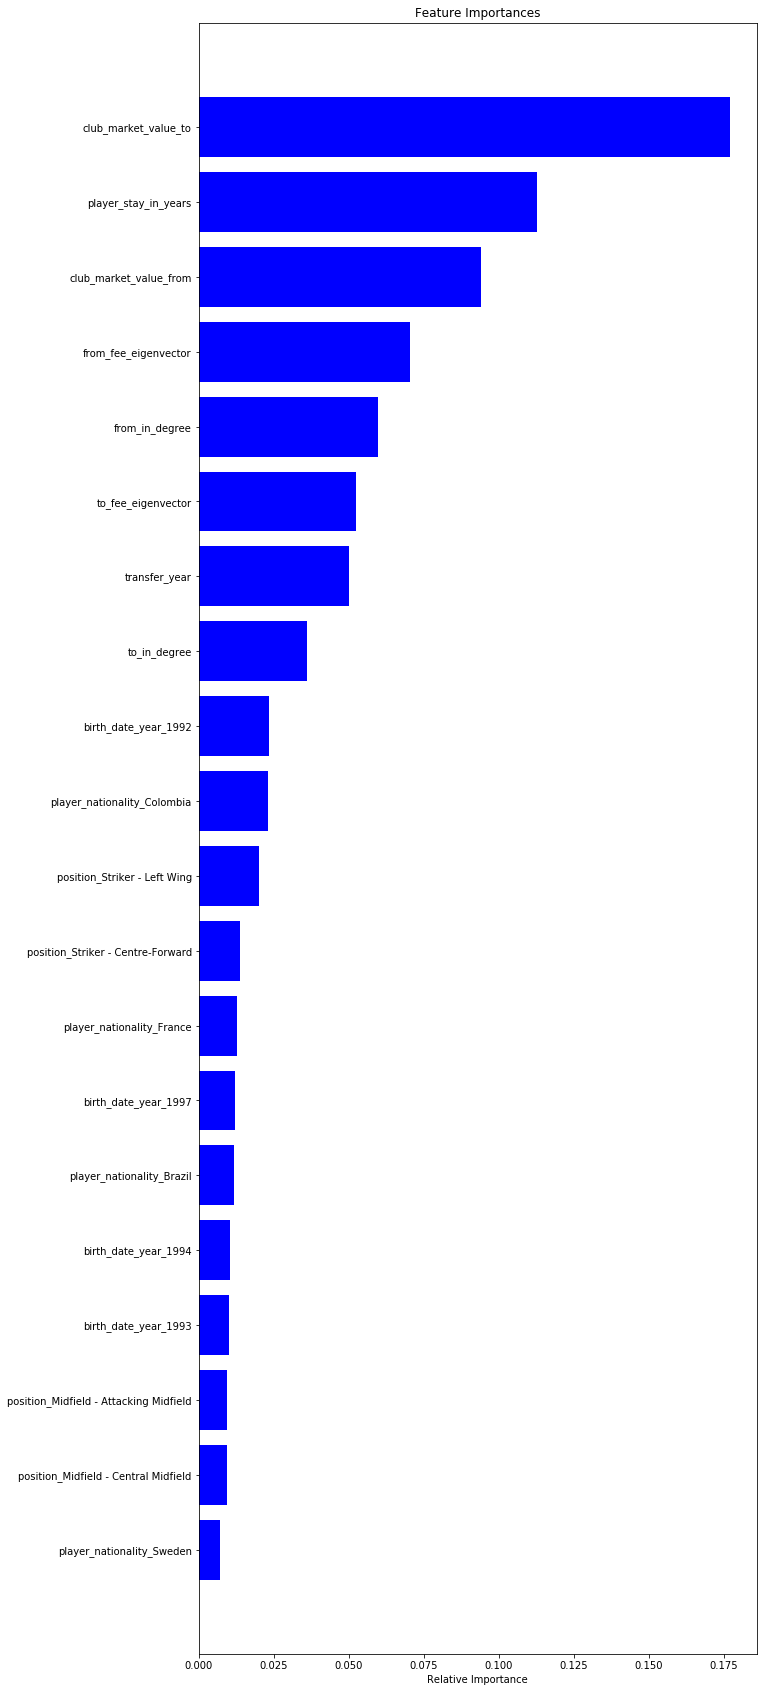

In [77]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[-20:]


plt.figure(figsize=(10,30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Analysis

## Conclusion

## Appendix: Project Structure